Name: T R Hari Subramaniam

Roll: AM.EN.U4CSE19056

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install jovian opendatasets --upgrade --quiet
import opendatasets as od

In [2]:
dataset_url = 'https://www.kaggle.com/omeret/not-safe-for-work'

In [3]:
!pip install jovian opendatasets --upgrade --quiet
import opendatasets as od
od.download(dataset_url)

Skipping, found downloaded files in "./not-safe-for-work" (use force=True to force download)


In [4]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
import torchvision.transforms as transforms

In [5]:
data_dir = './not-safe-for-work'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['nsfw', 'sfw']


In [6]:
mean = torch.tensor([0.5, 0.5, 0.5], dtype=torch.float32)
std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=40),

    transforms.Resize(256),
    transforms.CenterCrop(256),

    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [7]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [8]:
trainset = ImageFolder(data_dir+'/train', transform=transform)
testset = ImageFolder(data_dir+'/test', transform=transform)

In [9]:
trainset

Dataset ImageFolder
    Number of datapoints: 98531
    Root location: ./not-safe-for-work/train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.3)
               RandomRotation(degrees=[-40.0, 40.0], interpolation=nearest, expand=False, fill=0)
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(256, 256))
               ToTensor()
               Normalize(mean=tensor([0.5000, 0.5000, 0.5000]), std=tensor([0.2290, 0.2240, 0.2250]))
           )

In [10]:
trainset_subset = torch.utils.data.Subset(trainset, np.random.choice(len(trainset), 5000, replace=False))
testset_subset = torch.utils.data.Subset(testset, np.random.choice(len(testset), 1000, replace=False))

In [11]:
img, label = trainset_subset[0]
print(img.shape, label)
img

torch.Size([3, 256, 256]) 0


tensor([[[-2.1834, -2.1834, -2.1834,  ...,  1.7382,  1.7553,  1.7724],
         [-2.1834, -2.1834, -2.1834,  ...,  1.7553,  1.7724,  1.7724],
         [-2.1834, -2.1834, -2.1834,  ...,  1.7724,  1.7724,  1.7724],
         ...,
         [ 1.6183,  1.6012,  1.6183,  ..., -2.1834, -2.1834, -2.1834],
         [ 1.6354,  1.6012,  1.6183,  ..., -2.1834, -2.1834, -2.1834],
         [ 1.6354,  1.6012,  1.5840,  ..., -2.1834, -2.1834, -2.1834]],

        [[-2.2321, -2.2321, -2.2321,  ...,  1.4443,  1.4443,  1.4268],
         [-2.2321, -2.2321, -2.2321,  ...,  1.4268,  1.4268,  1.4268],
         [-2.2321, -2.2321, -2.2321,  ...,  1.4268,  1.4268,  1.4268],
         ...,
         [ 0.4814,  0.4814,  0.4989,  ..., -2.2321, -2.2321, -2.2321],
         [ 0.4814,  0.4639,  0.4989,  ..., -2.2321, -2.2321, -2.2321],
         [ 0.4989,  0.4814,  0.4639,  ..., -2.2321, -2.2321, -2.2321]],

        [[-2.2222, -2.2222, -2.2222,  ...,  1.1939,  1.1939,  1.1939],
         [-2.2222, -2.2222, -2.2222,  ...,  1

In [12]:
train_dataloader = torch.utils.data.DataLoader(
    dataset=trainset_subset,
    batch_size=16,
    shuffle=False,
    num_workers=2
)

In [13]:
test_dataloader = torch.utils.data.DataLoader(
    dataset=testset_subset,
    batch_size=16,
    shuffle=False,
    num_workers=2
)

Hidden Layers, Activation Functions and Non-Linearity

In [14]:
input_size = 65536*3
hidden_size = 500 
num_classes = 2
num_epochs = 10
batch_size = 100
learning_rate = 0.001 

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
import torch.nn as nn

In [17]:
class NeuralNet1(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet1, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.LogSigmoid = nn.LogSigmoid()
        self.l2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.l1(x)
        out = self.LogSigmoid(out)
        out = self.l2(out)
        # no activation and no softmax at the end
        return out

model1 = NeuralNet1(input_size, hidden_size, num_classes).to(device)

In [18]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model1.parameters(), lr=learning_rate) 

In [19]:
loss_val = []
n_total_steps = len(train_dataloader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dataloader):  
        # origin shape: [100, 1, 28, 28]
        # resized: [100, 784]
        images = images.reshape(-1, 256*256*3).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model1(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if (i+1) % 100 == 0:
          print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
          loss_val.append(loss.item())

Epoch [1/10], Step [100/313], Loss: 0.5077
Epoch [1/10], Step [200/313], Loss: 0.5381
Epoch [1/10], Step [300/313], Loss: 0.6607
Epoch [2/10], Step [100/313], Loss: 0.6330
Epoch [2/10], Step [200/313], Loss: 0.3699
Epoch [2/10], Step [300/313], Loss: 0.5469
Epoch [3/10], Step [100/313], Loss: 0.6339
Epoch [3/10], Step [200/313], Loss: 0.3793
Epoch [3/10], Step [300/313], Loss: 0.6534
Epoch [4/10], Step [100/313], Loss: 0.4161
Epoch [4/10], Step [200/313], Loss: 0.3955
Epoch [4/10], Step [300/313], Loss: 0.7184
Epoch [5/10], Step [100/313], Loss: 0.5810
Epoch [5/10], Step [200/313], Loss: 0.3445
Epoch [5/10], Step [300/313], Loss: 0.5548
Epoch [6/10], Step [100/313], Loss: 0.4220
Epoch [6/10], Step [200/313], Loss: 0.4168
Epoch [6/10], Step [300/313], Loss: 0.6084
Epoch [7/10], Step [100/313], Loss: 0.3429
Epoch [7/10], Step [300/313], Loss: 0.6643
Epoch [8/10], Step [100/313], Loss: 0.4976
Epoch [8/10], Step [200/313], Loss: 0.4859
Epoch [8/10], Step [300/313], Loss: 0.5295
Epoch [9/10

In [22]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_dataloader:
        images = images.reshape(-1, 256*256*3).to(device)
        labels = labels.to(device)
        outputs = model1(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 5000 test images: {acc} %')

Accuracy of the network on the 5000 test images: 72.4 %


In [23]:
input_size = 65536*3
hidden_size = 100
num_classes = 2
#num_epochs = 10
batch_size = 100
learning_rate = 0.001 

In [24]:
class NeuralNet2(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet2, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.LogSigmoid = nn.LogSigmoid()
        self.l2 = nn.Linear(hidden_size, hidden_size) 
        self.LogSigmoid1 = nn.LogSigmoid()
        self.l3 = nn.Linear(hidden_size, hidden_size)  
        self.LogSigmoid2 = nn.LogSigmoid()
        self.l4 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.l1(x)
        out = self.LogSigmoid(out)
        out = self.l2(out)
        out = self.LogSigmoid(out)
        out = self.l3(out)
        out = self.LogSigmoid(out)
        out = self.l4(out)
        # no activation and no softmax at the end
        return out

model1 = NeuralNet2(input_size, hidden_size, num_classes).to(device)

In [25]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model1.parameters(), lr=learning_rate) 

In [26]:
n_total_steps

313

In [31]:
num_epochs = 15
loss_val1 = []
los_val1 = []
n_total_steps = len(train_dataloader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dataloader):  
        # origin shape: [100, 1, 28, 28]
        # resized: [100, 784]
        images = images.reshape(-1, 256*256*3).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model1(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        los_val1.append(loss.item())

        if (i+1) % 100 == 0:
          print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
          loss_val1.append(loss.item())

Epoch [1/15], Step [100/313], Loss: 0.4768
Epoch [1/15], Step [200/313], Loss: 0.3925
Epoch [1/15], Step [300/313], Loss: 0.5122
Epoch [2/15], Step [100/313], Loss: 0.4662
Epoch [2/15], Step [200/313], Loss: 0.4139
Epoch [2/15], Step [300/313], Loss: 0.5803
Epoch [3/15], Step [100/313], Loss: 0.4285
Epoch [3/15], Step [200/313], Loss: 0.3849
Epoch [3/15], Step [300/313], Loss: 0.4788
Epoch [4/15], Step [100/313], Loss: 0.4463
Epoch [4/15], Step [200/313], Loss: 0.3503
Epoch [4/15], Step [300/313], Loss: 0.4562
Epoch [5/15], Step [100/313], Loss: 0.5068
Epoch [5/15], Step [200/313], Loss: 0.3896
Epoch [5/15], Step [300/313], Loss: 0.6724
Epoch [6/15], Step [100/313], Loss: 0.4833
Epoch [6/15], Step [200/313], Loss: 0.4026
Epoch [6/15], Step [300/313], Loss: 0.6018
Epoch [7/15], Step [100/313], Loss: 0.5192
Epoch [7/15], Step [200/313], Loss: 0.3737
Epoch [7/15], Step [300/313], Loss: 0.5846
Epoch [8/15], Step [100/313], Loss: 0.5070
Epoch [8/15], Step [200/313], Loss: 0.4646
Epoch [8/15

In [32]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_dataloader:
        images = images.reshape(-1, 256*256*3).to(device)
        labels = labels.to(device)
        outputs = model1(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 5000 test images: {acc} %')

Accuracy of the network on the 5000 test images: 74.5 %


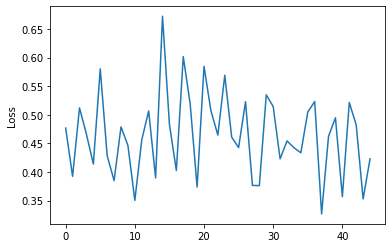

In [36]:
with torch.no_grad():
    plt.plot(loss_val1)
    plt.ylabel("Loss")
    plt.plot()

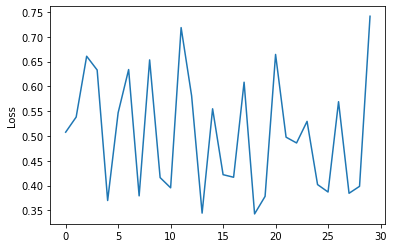

In [39]:
with torch.no_grad():
    plt.plot(loss_val)
    plt.ylabel("Loss")
    plt.plot()

In [38]:
num_epochs = 5
loss_val2 = []
n_total_steps = len(train_dataloader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dataloader):  
        # origin shape: [100, 1, 28, 28]
        # resized: [100, 784]
        images = images.reshape(-1, 256*256*3).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model1(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        

        if (i+1) % 100 == 0:
          print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
          loss_val2.append(loss.item())

Epoch [1/5], Step [100/313], Loss: 0.5588
Epoch [1/5], Step [200/313], Loss: 0.4059
Epoch [1/5], Step [300/313], Loss: 0.4867
Epoch [2/5], Step [100/313], Loss: 0.4580
Epoch [2/5], Step [200/313], Loss: 0.3571
Epoch [2/5], Step [300/313], Loss: 0.5735
Epoch [3/5], Step [100/313], Loss: 0.4314
Epoch [3/5], Step [200/313], Loss: 0.3655
Epoch [3/5], Step [300/313], Loss: 0.5047
Epoch [4/5], Step [100/313], Loss: 0.4445
Epoch [4/5], Step [200/313], Loss: 0.4266
Epoch [4/5], Step [300/313], Loss: 0.4159
Epoch [5/5], Step [100/313], Loss: 0.5920
Epoch [5/5], Step [200/313], Loss: 0.3811
Epoch [5/5], Step [300/313], Loss: 0.4333


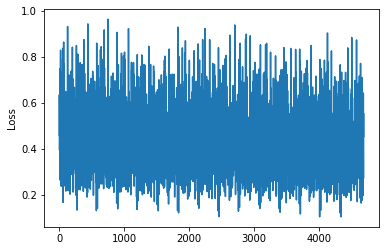

In [40]:
with torch.no_grad():
    plt.plot(los_val1)
    plt.ylabel("Loss")
    plt.plot()

In [41]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_dataloader:
        images = images.reshape(-1, 256*256*3).to(device)
        labels = labels.to(device)
        outputs = model1(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 5000 test images: {acc} %')

Accuracy of the network on the 5000 test images: 75.6 %
